# Task 7 : Stock Market Prediction using Numerical and Textual Analysis

# GRIP @ The Sparks Foundation


# Author : Abhinav Sharma

### Dataset : https://bit.ly/36fFPI6

###### In this task I tried to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.  

 

# Step 0: Importing Libraries needed to perform task

In [30]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [31]:
#ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

# Step 1 : Downloading and Reading The Data Set

In [32]:
pip install yfinance --upgrade --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
import yfinance as yf
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-06-30')
#since our Textual Analysis dataset containing news from Times of India News Headlines is only till 30th June 2020. 
#So we will assume today is 29th June 2020 and tomorrow is 30th June 2020. And we have to predict the stock price ((high+low+close)/3) and closing price of BSE index 
#for tomorrow 30th June 2020.
unseenbse_data = yf.download('^BSESN', start='2020-06-30', end='2020-07-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [35]:
bse_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [36]:
unseenbse_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [37]:
bse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [38]:
unseenbse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [39]:
bse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume':  'Volume' , 'Object' : 'object'} )

,open,high,low,close,adjclose,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200
...,...,...,...,...,...,...
2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200
2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600
2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600


In [40]:
unseenbse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume':  'Volume' , 'Object' : 'object'} )

,open,high,low,close,adjclose,Volume
Date,,,,,,
2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


# Step 2 : Checking the dataset's information

In [41]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2015-01-02 to 2020-06-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1345 non-null   float64
 1   High       1345 non-null   float64
 2   Low        1345 non-null   float64
 3   Close      1345 non-null   float64
 4   Adj Close  1345 non-null   float64
 5   Volume     1345 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.6 KB


In [42]:
unseenbse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2020-06-30 to 2020-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1 non-null      float64
 1   High       1 non-null      float64
 2   Low        1 non-null      float64
 3   Close      1 non-null      float64
 4   Adj Close  1 non-null      float64
 5   Volume     1 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 56.0 bytes


In [43]:
bse_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [44]:
bse_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200
2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600
2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600
2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800
2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300


In [45]:
unseenbse_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


In [46]:
bse_data.reset_index(inplace=True)

In [47]:
bse_data.rename(columns={'Date': 'date'}, inplace = True)

In [48]:
bse_data.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [49]:
unseenbse_data.reset_index(inplace=True)

In [50]:
unseenbse_data.rename(columns={'Date': 'date'}, inplace = True)

In [51]:
unseenbse_data.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


In [52]:
bse_data['date'] = pd.to_datetime(bse_data['date'], format = '%Y%m%d')

In [53]:
unseenbse_data['date'] = pd.to_datetime(unseenbse_data['date'], format = '%Y%m%d')

In [54]:
#before moving forward let us calculate first the actual price
unseenbsedata_price = round((unseenbse_data[ 'High' ] + unseenbse_data['Low'] + unseenbse_data['Close'])/ 3, 2)
unseenbsedata_price  #actual price

0    34987.5
dtype: float64

# Step 3 : Rolling window analysis of time series

#### Creating 4,16, 52 week moving average of closing price of BSE index

In [55]:
def stock_weekmovingavg(wks, df):
    dateclose_data = pd.DataFrame({'date': df['date'], 'Close':df['Close']})
    dateclose_data.set_index('date', inplace=True)
    num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
    dateclose_data['movingavg'] = dateclose_data['Close'].rolling(window=num).mean().shift()
    return dateclose_data.dropna()

In [56]:
stock_weekmovingavg(4, bse_data).head()

,Close,movingavg
date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984


<Axes: xlabel='date'>

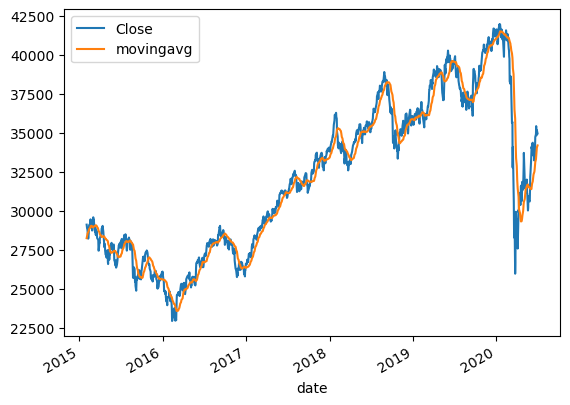

In [57]:
stock_weekmovingavg(4, bse_data).plot()

In [58]:
altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

In [59]:
alt.Chart(altdata_fourweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

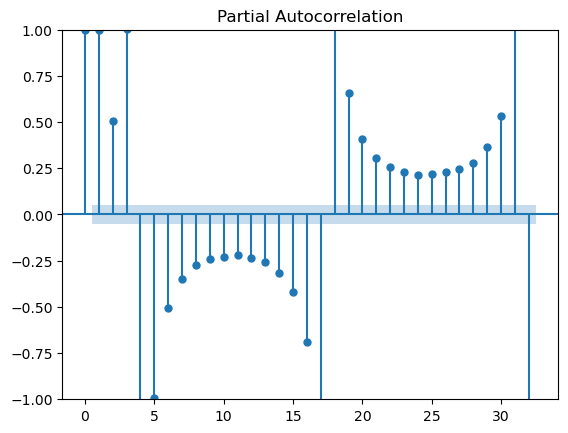

In [60]:
plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 
del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

In [61]:
stock_weekmovingavg(16, bse_data).head()

,Close,movingavg
date,,
2015-05-05,27440.140625,28447.880933
2015-05-06,26717.369141,28442.283936
2015-05-07,26599.109375,28428.222046
2015-05-08,27105.390625,28423.367651
2015-05-11,27507.300781,28425.824780


<Axes: xlabel='date'>

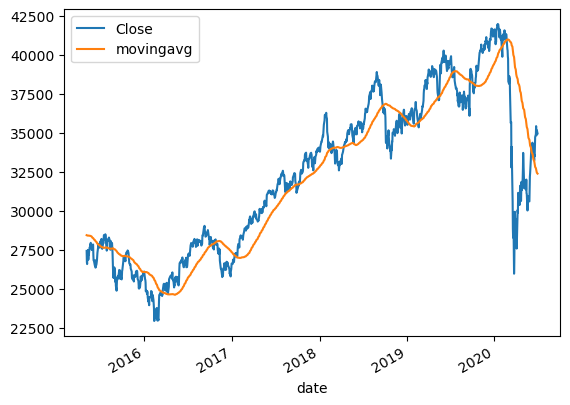

In [62]:
stock_weekmovingavg(16, bse_data).plot()

In [63]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)

In [64]:
alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

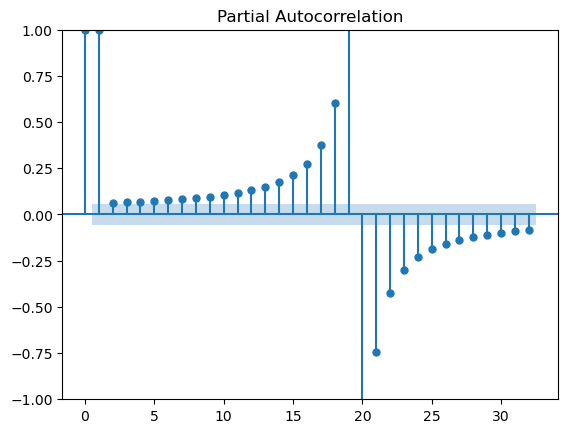

In [65]:
plotsixteenweek = altdata_sixteenweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_sixteenweek['date']))) 
del plotsixteenweek['date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()

###### In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 4 and 32. Since it is less than 0 and more than -1 so 4 and 32 represents a perfect negative correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)



In [66]:
stock_weekmovingavg(52, bse_data).head()

,Close,movingavg
date,,
2016-01-25,24485.949219,27198.907963
2016-01-27,24492.390625,27185.823535
2016-01-28,24469.570312,27172.939190
2016-01-29,24870.689453,27163.254995
2016-02-01,24824.830078,27155.416031


<Axes: xlabel='date'>

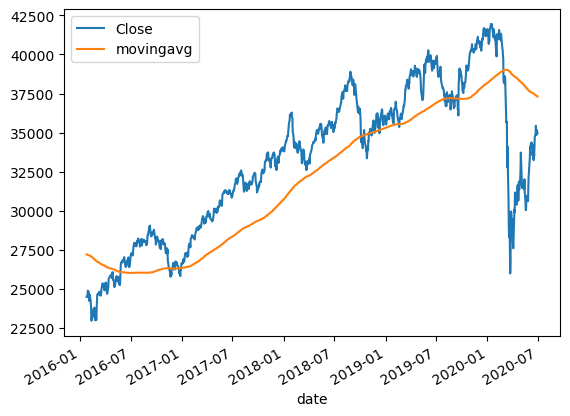

In [67]:
stock_weekmovingavg(52, bse_data).plot()

In [68]:
altdata_fiftytwoweek = stock_weekmovingavg(52, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'date'}, inplace=True)

In [69]:
alt.Chart(altdata_fiftytwoweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

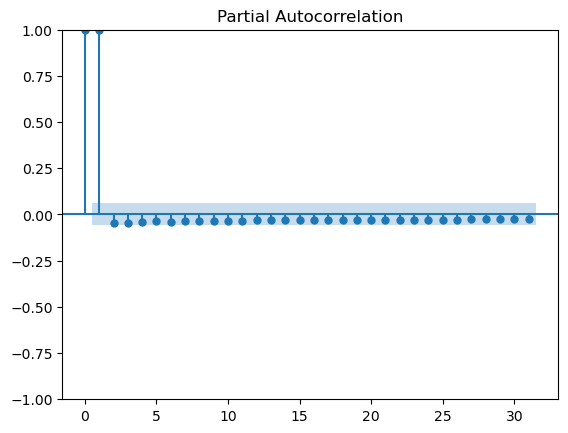

In [70]:
plotfiftytwoweek = altdata_fiftytwoweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['date']))) 
del plotfiftytwoweek['date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()

# Step 4 : Creating a rolling window of size 10 and 50 of the BSE index

In [71]:
def rollingwindows(days, df):
    data = df.filter(['date','Open','High','Low','Close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    rollingwindows_data = data.rolling(window=days).mean().shift()
    return rollingwindows_data.dropna()

In [72]:
rollingwindows(10, bse_data).head()

,Open,High,Low,Close
date,,,,
2015-01-16,27515.904883,27657.483008,27279.612891,27479.296484
2015-01-19,27569.437891,27681.345898,27322.217969,27502.695508
2015-01-20,27596.578906,27708.302930,27363.268945,27544.664453
2015-01-21,27659.640820,27821.338867,27502.047852,27724.385352
2015-01-22,27845.606836,28011.988867,27703.692969,27922.389258


<Axes: xlabel='date'>

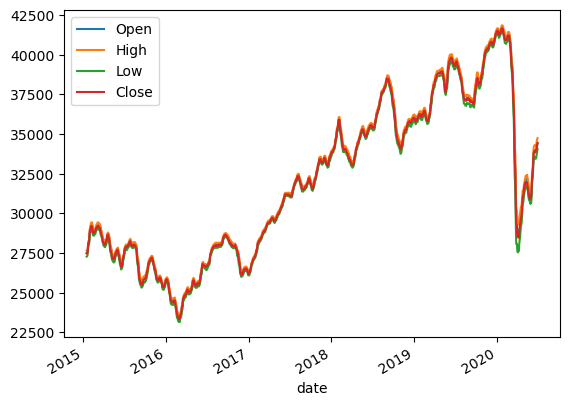

In [73]:
rollingwindows(10, bse_data).plot()

In [74]:
altdata_tendays = rollingwindows(10, bse_data)
altdata_tendays.reset_index(inplace=True)
altdata_tendays.rename(columns={list(altdata_tendays)[0]:'date'}, inplace=True)

In [75]:
alt.Chart(altdata_tendays).mark_point().encode(
    x ='date',
    y = 'Close'
)

alt.Chart(...)

In [76]:
rollingwindows(50, bse_data).head()

,Open,High,Low,Close
date,,,,
2015-03-18,28721.847383,28863.956836,28502.767422,28670.602461
2015-03-19,28746.759180,28881.346836,28523.317422,28685.286836
2015-03-20,28763.295000,28899.631836,28535.814414,28697.833828
2015-03-23,28778.719180,28915.340430,28561.266406,28723.306211
2015-03-24,28805.396367,28942.011250,28589.022031,28748.970195


<Axes: xlabel='date'>

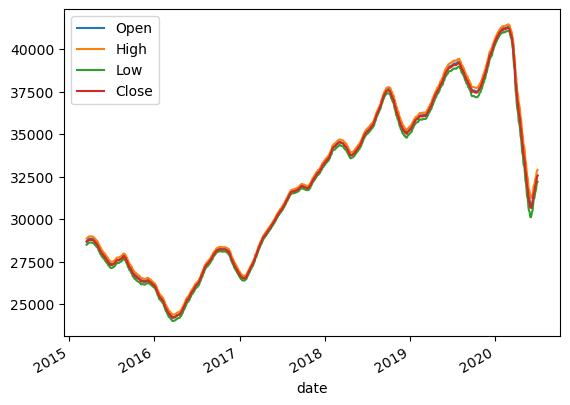

In [77]:
rollingwindows(50, bse_data).plot()

In [78]:
altdata_fiftydays = rollingwindows(50, bse_data)
altdata_fiftydays.reset_index(inplace=True)
altdata_fiftydays.rename(columns={list(altdata_fiftydays)[0]:'date'}, inplace=True)

In [79]:
alt.Chart(altdata_fiftydays).mark_point().encode(
    x='date',
    y='Close'
)

alt.Chart(...)

# Step 5 : Creating the dummy time series:

###### Volume shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether volume traded is 10% higher/lower than previous day. ( 0/1 dummy-coding is for direction of shock)

In [80]:
def boolean_shock(percent, df, col):
    data = df.filter(['date', col], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data['percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
    data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(col, axis = 1, inplace = True)
    return data.dropna()

In [81]:
boolean_shock(10, bse_data, 'Volume')

,percentchg,shock
date,,
2015-01-05,24.324324,1
2015-01-06,53.260870,1
2015-01-07,-13.475177,0
2015-01-08,-32.786885,0
2015-01-09,35.365854,1
...,...,...
2020-06-23,0.398406,0
2020-06-24,5.555556,0
2020-06-25,-7.518797,0


In [82]:
altdata_volpercentchg = boolean_shock(10, bse_data, 'Volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'date'}, inplace=True)

In [83]:
alt.Chart(altdata_volpercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

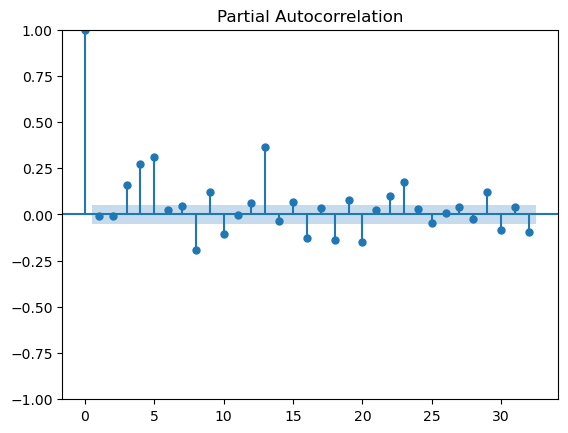

In [84]:
plotvolpercentchg = altdata_volpercentchg.filter(['date', 'percentchg'], axis=1) #df.copy()
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_volpercentchg['date']))) 
del plotvolpercentchg['date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

###### In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 3, 4, 5, 8, 9. 10, 12, 13, 15, 16, 18, 19, 20, 22, 23, 29, 30, 32. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

In [85]:
boolean_shock(2, bse_data, 'Close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


In [86]:
altdata_closepercentchg2 = boolean_shock(2, bse_data, 'Close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'date'}, inplace=True)

In [87]:
alt.Chart(altdata_closepercentchg2).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

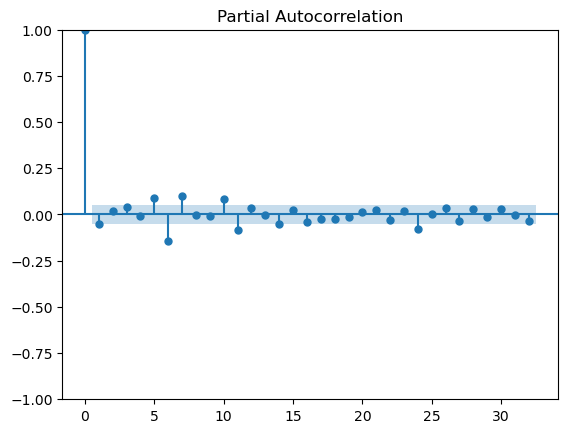

In [88]:
plotclosepercentchg2 = altdata_closepercentchg2.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['date']))) 
del plotclosepercentchg2['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In [89]:
boolean_shock(10, bse_data, 'Close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


In [90]:
altdata_closepercentchg10 = boolean_shock(10, bse_data, 'Close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'date'}, inplace=True)

In [91]:
alt.Chart(altdata_closepercentchg10).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

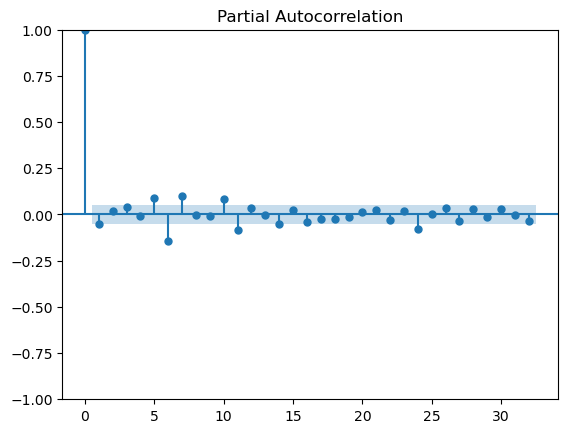

In [92]:
plotclosepercentchg10 = altdata_closepercentchg10.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg10['date']))) 
del plotclosepercentchg10['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg10.values.squeeze())
plt.show()

###### In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

# Step 6 : Pricing shock without volume shock

In [93]:
def priceboolean_shock(percent, df):
    df['date'] = pd.to_datetime(df['date'])
    data = df.filter(['date', 'High', 'Low','Close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data['priceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['shock'] = (data['priceavg'].pct_change()) * 100
    data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
    return data

In [94]:
priceboolean_shock(10, bse_data)

,priceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


In [95]:
altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'date'}, inplace=True)

In [96]:
alt.Chart(altdata_pricepercentchg).mark_point().encode(
    x='date',
    y='priceavg'
)

alt.Chart(...)

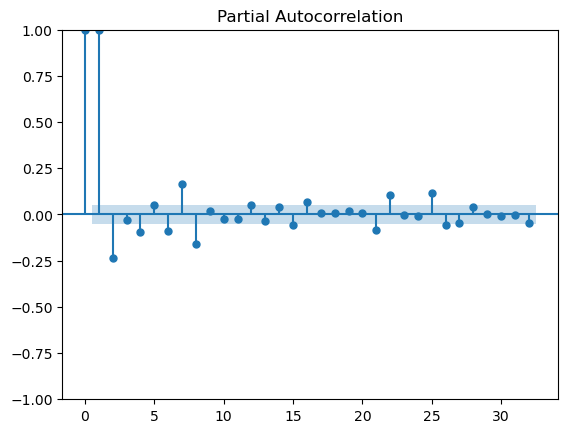

In [97]:
plotpricepercentchg = altdata_pricepercentchg.filter(['date', 'priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_pricepercentchg['date']))) 
del plotpricepercentchg['date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()

# Step 7 : Creating the reverse dummy time series: 

###### Price shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether closing price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [98]:
def reverseboolean_shock(percent, df, col):
    data = df.filter(['date', col], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['percentchg'] = (data[col].pct_change()) * 100
    data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
    data.drop(col, axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [99]:
reverseboolean_shock(2, bse_data, 'Close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,1
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [100]:
altdata_closepercentchg = reverseboolean_shock(2, bse_data, 'Close')
altdata_closepercentchg.reset_index(inplace=True)
altdata_closepercentchg.rename(columns={list(altdata_closepercentchg)[0]:'date'}, inplace=True)

In [101]:
alt.Chart(altdata_closepercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)


alt.Chart(...)

In [102]:
reverseboolean_shock(5, bse_data, 'Close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,0
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [103]:
altdata_closepercentchg5 = reverseboolean_shock(5, bse_data, 'Close')
altdata_closepercentchg5.reset_index(inplace=True)
altdata_closepercentchg5.rename(columns={list(altdata_closepercentchg5)[0]:'date'}, inplace=True)

In [104]:
alt.Chart(altdata_closepercentchg5).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [105]:
def pricereverseboolean_shock(percent, df):
    data = df.filter(['date', 'High', 'Low','Close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['reversepriceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['shock'] = (data['reversepriceavg'].pct_change()) * 100
    data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [106]:
pricereverseboolean_shock(2, bse_data)

,reversepriceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


In [107]:
altdata_reversepricepercentchg = pricereverseboolean_shock(2, bse_data)
altdata_reversepricepercentchg.reset_index(inplace=True)
altdata_reversepricepercentchg.rename(columns={list(altdata_reversepricepercentchg)[0]:'date'}, inplace=True)

In [108]:
alt.Chart(altdata_reversepricepercentchg).mark_point().encode(
    x='date',
    y='reversepriceavg'
)

alt.Chart(...)

# Step 8 : Textual Analysis of news from Times of India News Headlines


In [109]:
#reading the uploaded csv file and assigning to news variable
news  = pd.read_csv('newdata.csv')

In [110]:
#getting the overview of all the columns in the news dataset
news.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [111]:
#finding the total rows and columns of news dataset
news.shape

(3650970, 3)

In [112]:
#first 5 rows content of the dataset
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [113]:
#converting publish_date column to 
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')

In [114]:
#first 5 rows content of the dataset
news.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [115]:
#last 5 rows content of the dataset
news.tail()

,publish_date,headline_category,headline_text
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...
3650969,2022-03-31,city.salem,Tamil Nadu sees marginal rise of Covid cases w...


In [116]:
#getting brief overview of the dataset - number of columns and rows (shape of dataset), columns names and its dtype, how many non-null values it has and memory usage.
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [117]:
#finding unique values in headline_category
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [118]:
#checking all the values count (unique values total count)
news['headline_category'].value_counts()

india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [119]:
#total unique values count
news['headline_category'].value_counts().count()

1041

In [120]:
#checking all the values count (unique values total count)
news['headline_text'].value_counts()

Straight Answers                                                                                                          6723
Cartoons                                                                                                                  1536
Straight answers                                                                                                          1500
Photogallery                                                                                                              1353
Your say                                                                                                                  1012
                                                                                                                          ... 
Pak President Asif Ali Zardari at 7RCR; meets Manmohan Singh                                                                 1
Why Goa Inc is so happy with CM Manohar Parrikar                                                               

In [121]:
#total unique values count
news['headline_text'].value_counts().count()


3387380

In [122]:
#finding if any null values are present
news.isnull().sum().sum()

0

In [123]:
#finding if any duplicate values are present
news.duplicated().sum()

24860

In [124]:
#rough checking by marking all duplicates as True. Default is first which marks duplicates as True except for the first occurrence.
news.duplicated(keep=False).sum()

47452

In [125]:
#sorting the dataset to delete the duplicates, to make duplicates come together one after another. The sorted dataset index values are also changed
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)

In [126]:
news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
9,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3646165,2022-03-22,city.hubballi,BJP divided over probable induction of Basavar...
3648600,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3648601,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3649664,2022-03-29,city.hyderabad,Telangana logs 30 new Covid cases


In [127]:
#dropping the duplicates only keeping the last value (ordinally last row from sorted) of each duplicates
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [128]:
#re-checking everything worked well with drop_duplicates() carried out earlier on the dataset
news.duplicated().sum()

0

In [129]:
pip install textblob

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [130]:
from textblob import TextBlob

In [131]:
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

In [132]:
#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
    df = news.loc[news['publish_date'] == x]
    headlinetext = ''
    publishdate = str(x)
    headlinetext = df['headline_text'].iloc[0]
    for i in range(1 , len(df)):
        headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
    new.append(headlinetext)

In [133]:
#creating a new dataset
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [134]:
newsdf

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-12-27,New generation Audi Q7 being tested in India. ...
...,...,...
7712,2001-03-02,Such A Long Journey
7713,2001-05-25,What Women Want
7714,2001-06-05,Darkness Triumphs
7715,2001-03-16,Tape and Tell


In [135]:
#sorting the dataset based on dates
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)

In [136]:
newsdf.head()

,publish_date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...


In [137]:
newsdf.tail()

,publish_date,headline_text
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...
7713,2022-03-28,Adani Total forays into electric mobility infr...
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....
7716,2022-03-31,$50 million fund for Apple's supplier employee...


In [138]:
newsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7717 entries, 0 to 7716
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publish_date   7717 non-null   datetime64[ns]
 1   headline_text  7717 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 120.7+ KB


In [139]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
    polarity.append(TextBlob(row['headline_text']).sentiment[0])
    subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [140]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

In [141]:
newsdf.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [142]:
newsdf.tail()

,publish_date,headline_text,polarity,subjectivity
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...,0.026188,0.371042
7713,2022-03-28,Adani Total forays into electric mobility infr...,0.055232,0.389939
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...,0.095037,0.404044
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....,0.037729,0.350965
7716,2022-03-31,$50 million fund for Apple's supplier employee...,0.023654,0.338593


In [143]:
#finding if any null values are present
newsdf.isnull().sum().sum()

0

In [144]:
#renameing the publish_date to date so it will help us during joining this dataset with bse_data dataset
newsdf.rename(columns={'publish_date': 'date'}, inplace = True)

In [145]:
#selecting required columns
newsdf = newsdf.filter(['date', 'polarity', 'subjectivity'], axis=1)

In [146]:
newsdf.shape

(7717, 3)

In [147]:
newsdf['date'].duplicated().sum()

0

In [148]:
bse_data.shape

(1345, 7)

In [149]:
bse_data['date'].duplicated().sum()

0

In [150]:
bse_data = pd.merge(bse_data, newsdf, how='left', on=['date'])

In [151]:
bse_data.shape

(1345, 9)

In [152]:
bse_data.head()

,date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [153]:
bse_data.tail()

,date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200,0.067428,0.370002
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800,0.069594,0.381331
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300,0.056935,0.387858


In [154]:
#finding if any null values are present
bse_data.isnull().sum().sum()

0

# Step 9 : Preparing the dataset for machine learning

In [155]:
#adding new row for 30th June 2020 (price to be predicted of this day) to main dataset to get average values of all the columns for this day
#taking average because we don't know the values of all the columns for tomorrow so to predict we need average for independent variable.
#We will separate this row later from this main dataset so we can use this as prediction of unseen data for tomorrow. 
#And then tally it with actual data from unseenbse_data dataset which we have downloaded too for 30th June 2020 actual values
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['Open'].mean(), bse_data['High'].mean(), bse_data['Low'].mean(),
                       bse_data['Close'].mean(), bse_data['Adj Close'].mean(), bse_data['Volume'].median(), newsdf['polarity'].mean() , newsdf['subjectivity'].mean()]

In [156]:
#converting date from object dtype to datetime dtype
bse_data['date'] = pd.to_datetime(bse_data['date'], format="%Y-%m-%d")

In [157]:
bse_data.tail()

,date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600.0,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600.0,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800.0,0.069594,0.381331
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300.0,0.056935,0.387858
1345,2020-06-30,32032.534800,32180.642524,31806.772791,31984.237075,31984.237075,12700.0,0.068447,0.402597


In [158]:
bse_data["month"] = bse_data['date'].dt.month
bse_data["day"] = bse_data['date'].dt.day
bse_data["dayofweek"] = bse_data['date'].dt.dayofweek
bse_data["week"] = bse_data['date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['Close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['Close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['Close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['Close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['Close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['Close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['Close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeshock'] = round(boolean_shock(10, bse_data, 'Volume').reset_index()['shock'], 2)
bse_data['closeshock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['closeshock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['shock'],2)
bse_data['closeshock10'] = round(reverseboolean_shock(10, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['priceshock'] = round(priceboolean_shock(10, bse_data).reset_index()['shock'], 2)
bse_data['reversebooleanshock2'] = round(reverseboolean_shock(2, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['reversebooleanshock5'] = round(reverseboolean_shock(5, bse_data, 'Close').reset_index()['shock'], 2)
bse_data['pricereverseshock2'] = round(pricereverseboolean_shock(2, bse_data).reset_index()['shock'], 2)
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['High'] + bse_data['Low'] + bse_data['Close']) / 3 , 2)
bse_data['Close'] = round(bse_data['Close'] , 2)

In [159]:
bse_data.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'polarity', 'subjectivity', 'month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'price'],
      dtype='object')

In [160]:
bse_data

,date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity,month,...,window50days,volumeshock,closeshock2,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,price
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.90,27887.900391,7400.0,0.06,0.46,1,...,NaN,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27781.54
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.32,27842.320312,9200.0,0.10,0.43,1,...,27887.90,1.0,1.0,0.0,0.0,0,1.0,0.0,1,27897.89
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.46,26987.460938,14100.0,0.06,0.39,1,...,27865.11,0.0,0.0,0.0,0.0,0,0.0,0.0,0,27207.82
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.82,26908.820312,12200.0,0.03,0.39,1,...,27572.56,0.0,0.0,0.0,0.0,0,0.0,0.0,0,26912.18
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.71,27274.710938,8200.0,0.06,0.41,1,...,27406.63,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27231.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.98,34868.980469,26600.0,0.09,0.39,6,...,32303.70,0.0,0.0,0.0,0.0,0,0.0,0.0,0,35123.49
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.10,34842.101562,24600.0,0.02,0.40,6,...,32377.89,0.0,0.0,0.0,0.0,0,0.0,0.0,0,34807.83
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.27,35171.269531,24800.0,0.07,0.38,6,...,32460.93,0.0,0.0,0.0,0.0,0,0.0,0.0,0,35112.16
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.52,34961.519531,18300.0,0.06,0.39,6,...,32556.76,0.0,1.0,1.0,0.0,0,1.0,1.0,1,34885.31


In [161]:
#fillinf the null columns
bse_data.fillna(method = 'bfill', inplace = True)

In [162]:
#fillinf the null columns
bse_data.fillna(method = 'ffill', inplace = True)

In [163]:
#finding if any null values are present
bse_data.isnull().sum().sum()

0

In [164]:
#selecting specific columns
bse_data = bse_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'Close'], axis=1)

In [165]:
bse_data

,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,...,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,polarity,subjectivity,price,Close
0,1,2,4,1,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,...,0.0,0.0,0,0.0,0.0,0,0.06,0.46,27781.54,27887.90
1,1,5,0,2,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,...,0.0,0.0,0,1.0,0.0,1,0.10,0.43,27897.89,27842.32
2,1,6,1,2,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,...,0.0,0.0,0,0.0,0.0,0,0.06,0.39,27207.82,26987.46
3,1,7,2,2,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,...,0.0,0.0,0,0.0,0.0,0,0.03,0.39,26912.18,26908.82
4,1,8,3,2,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,...,0.0,0.0,0,0.0,0.0,0,0.06,0.41,27231.02,27274.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,6,24,2,26,33762.67,32586.53,36265.58,37002.15,37367.90,34118.98,...,0.0,0.0,0,0.0,0.0,0,0.09,0.39,35123.49,34868.98
1342,6,25,3,26,33925.86,32517.85,36221.64,36989.02,37350.08,34181.17,...,0.0,0.0,0,0.0,0.0,0,0.02,0.40,34807.83,34842.10
1343,6,26,4,26,34057.94,32449.86,36176.72,36975.03,37330.89,34311.54,...,0.0,0.0,0,0.0,0.0,0,0.07,0.38,35112.16,35171.27
1344,6,29,0,27,34195.30,32390.89,36136.56,36963.62,37313.42,34450.58,...,1.0,0.0,0,1.0,1.0,1,0.06,0.39,34885.31,34961.52


In [166]:
#separating the predicted date row from main dataset after getting all the calculated average values
main_bsedata = bse_data.iloc[:1345,:].reset_index()  
newtestunseen_bsedata = bse_data.iloc[1345:,:].reset_index()  

In [167]:
main_bsedata.shape

(1345, 24)

In [168]:
main_bsedata.tail()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,...,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,polarity,subjectivity,price,Close
1340,1340,6,23,1,26,33521.62,32658.27,36304.08,37008.50,37384.51,...,0.0,0.0,0,0.0,0.0,0,0.07,0.37,35252.09,35430.43
1341,1341,6,24,2,26,33762.67,32586.53,36265.58,37002.15,37367.90,...,0.0,0.0,0,0.0,0.0,0,0.09,0.39,35123.49,34868.98
1342,1342,6,25,3,26,33925.86,32517.85,36221.64,36989.02,37350.08,...,0.0,0.0,0,0.0,0.0,0,0.02,0.40,34807.83,34842.10
1343,1343,6,26,4,26,34057.94,32449.86,36176.72,36975.03,37330.89,...,0.0,0.0,0,0.0,0.0,0,0.07,0.38,35112.16,35171.27
1344,1344,6,29,0,27,34195.30,32390.89,36136.56,36963.62,37313.42,...,1.0,0.0,0,1.0,1.0,1,0.06,0.39,34885.31,34961.52


In [169]:
newtestunseen_bsedata.shape

(1, 24)

In [170]:
newtestunseen_bsedata.head()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,...,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,polarity,subjectivity,price,Close
0,1345,6,30,1,27,34278.2,32331.09,36094.84,36953.09,37293.01,...,1.0,0.0,0,1.0,1.0,0,0.07,0.4,31990.55,31984.24


In [171]:
print(main_bsedata.columns)


Index(['index', 'month', 'day', 'dayofweek', 'week', 'movingavg4weeks',
       'movingavg16weeks', 'movingavg28weeks', 'movingavg40weeks',
       'movingavg52weeks', 'window10days', 'window50days', 'volumeshock',
       'closeshock2', 'closeshock5', 'closeshock10', 'priceshock',
       'reversebooleanshock2', 'reversebooleanshock5', 'pricereverseshock2',
       'polarity', 'subjectivity', 'price', 'Close'],
      dtype='object')


# Step 10 : Training the model and predicting the price

In [172]:
X = main_bsedata.drop(['price', 'Close'], axis=1)
y = main_bsedata[['price', 'Close']]


In [173]:
Xnewtestunseen = newtestunseen_bsedata.drop(['price','Close'], axis = 1)
ynewtestunseen_ans = newtestunseen_bsedata[['price','Close']]

In [174]:
X.shape, y.shape

((1345, 22), (1345, 2))

In [175]:
Xnewtestunseen.shape, ynewtestunseen_ans.shape

((1, 22), (1, 2))

In [176]:
split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [177]:
 X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1076, 22), (1076, 2), (269, 22), (269, 2))

In [179]:
rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', max_depth = 30, min_samples_leaf=2, min_samples_split=2)

In [182]:
rfg = RandomForestRegressor(
    random_state=42,
    n_estimators=500,
    criterion='squared_error',  # Use 'squared_error' for MSE
    max_depth=30,
    min_samples_leaf=2,
    min_samples_split=2
)

# Create the RegressorChain model using the RandomForestRegressor instance
chainedmodel = RegressorChain(base_estimator=rfg)

chainedmodel.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=30,
                                                    min_samples_leaf=2,
                                                    n_estimators=500,
                                                    random_state=42))

In [183]:
pred = chainedmodel.predict(X_test)
roundpred = []
for x in range(len(pred)):
    roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])

In [184]:
r2_score(y_test, roundpred) 

0.9948111408673289

In [185]:
#evaluating the performance of the model
#MAE
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
#MSE
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
252.69431226765795
MSE
125758.45434869881
RMSE
354.6243848760246


In [186]:
pred_newtestunseen = chainedmodel.predict(Xnewtestunseen)

In [187]:
[(round(pred_newtestunseen[0][0], 2)),(round(pred_newtestunseen[0][1], 2))]

[35059.31, 34954.38]

In [188]:
ynewtestunseen_ans  #used average of high, low, close, volume to calculate price ((high+low+close)/3) and close value

,price,Close
0,31990.55,31984.24


In [190]:
[unseenbsedata_price[0] , round(unseenbse_data['Close'],2)[0]] #actual price ((high+low+close)/3) calculated earlier and the cl

[34987.5, 34915.8]

## A hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.